In [1]:
import json, os

import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [2]:
with open('msd-data/mfcc-features.json', 'r') as f:
    mfcc_features = json.load(f)
    for k, v in mfcc_features.items():
        mfcc_features[k] = np.array(v)

with open('msd-data/features.json', 'r') as f:
    msd_features = json.load(f)

In [63]:
# Computes approximate sinusoity between the straight line from source to target and the actual path
# https://en.wikipedia.org/wiki/Sinuosity
def sinusoity(all_features: set, straight_line_distance: float, path: list[str], source: str, dest: str, distance_function):
    total_distance = 0
    path = [source, *path, dest]

    for i in range(len(path) - 1):
        start_feats = all_features[path[i]]
        end_feats = all_features[path[i+1]]
        
        total_distance += distance_function(start_feats, end_feats)
    
    return total_distance / straight_line_distance

# Computes the RMS deviation for a path, given the line defined the the source and destination songs
# https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Vector_formulation
def rms_deviation(all_features: set, path: list[str], source: str, dest: str, distance_function, norm: int):
    start_feats = all_features[source]
    dest_feats = all_features[dest]

    if type(start_feats) == dict and type(dest_feats) == dict:
        start_feats = json_features_to_np(start_feats)
        dest_feats = json_features_to_np(dest_feats)
    
    # unit vector of the line x from start_feats to dest_feats
    n = (dest_feats - start_feats)
    n = n / np.linalg.norm(n, ord=2)

    deviations = []
    for id in path:
        p_feats = all_features[id]
        if type(p_feats) == dict:
            p_feats = json_features_to_np(p_feats)
        
        p_minus_a = p_feats - start_feats
        t2 = np.dot(p_minus_a, n) * n # corresponds to ((p - a) . n) * n

        # square_deviation += np.linalg.norm(p_minus_a - t2, ord=norm) ** 2
        deviations.append(np.linalg.norm(p_minus_a - t2, ord=norm))

    if np.std(deviations) == 0:
        print(path, source, dest)

    return (np.mean((np.array(deviations) ** 2)) ** 0.5)

In [109]:
def scatter_plot_results(all_features: set, RESULTS: str, distance_function, params: str, save_name: str, sinuosity: bool):
    result_set = {}
    metric = 'sinuosity' if sinuosity else 'RMS deviation'

    print('Loading results...')
    for n, result in enumerate(os.listdir(RESULTS)):
        if n % 250 == 0:
            print(f'Processing file #{n}...', end='\r')

        with open(f'{RESULTS}/{result}') as f:
            res_data = json.load(f)
            if type(res_data['SOURCE_FEATS']) == list:
                res_data['SOURCE_FEATS'] = np.array(res_data['SOURCE_FEATS'])
                res_data['TARGET_FEATS'] = np.array(res_data['TARGET_FEATS'])
                res_data['APPROX_FEATS'] = np.array(res_data['APPROX_FEATS'])

            if len(res_data['PATH']) > 1:
                result_set[result.strip('.json')] = res_data

    print('')

    found, not_found, path_lengths = [], [], []

    print('Calculating metrics...')
    for result in result_set.values():
        source_id, source_feats = result['meta']['SOURCE_ID'], result['SOURCE_FEATS']
        if result['meta']['FOUND']:
            end_id, end_feats = result['meta']['TARGET_ID'], result['TARGET_FEATS']
        else:
            end_id, end_feats = result['meta']['APPROX'], result['APPROX_FEATS']

        path_lengths.append(len(result['PATH']))

        straight_line_distance = distance_function(source_feats, end_feats)

        if sinuosity:
            straightness = sinusoity(all_features, straight_line_distance, result['PATH'], source_id, end_id, distance_function)
        else:
            straightness = rms_deviation(all_features, result['PATH'], source_id, end_id, distance_function, 1)
        
        distances = [(distance_function(all_features[p], source_feats), distance_function(all_features[p], end_feats)) for p in result['PATH']]

        fits_line = True
        for i, (d_src, d_dst) in enumerate(distances[:-1]):
            o_d_src, o_d_dst = distances[i+1]

            if d_src > o_d_src or d_dst < o_d_dst:
                fits_line = False
                break
        
        if fits_line:
            found.append([straight_line_distance, straightness])
        else:
            not_found.append([straight_line_distance, straightness])

    found = np.array(found)
    not_found = np.array(not_found)
    path_lengths = np.array(path_lengths)

    straightness_std = np.std(np.concatenate([found[:, 0], not_found[:, 0]]))
    found[:, 1] /= straightness_std
    not_found[:, 1] /= straightness_std

    print('Plotting...')

    fig, ax = plt.subplots()

    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.set_xlabel('Straight-line distance from source to target')
    ax.set_ylabel(f'Path {metric}')
    ax.set_title(f'Distance-Straightness Scatter Plot: {params}')

    found_color = '#0044dd'
    not_found_color = '#de7733'

    ax.scatter(not_found[:, 0], not_found[:, 1], c=[not_found_color for _ in not_found], label="Doesn't fit")
    ax.scatter(found[:, 0], found[:, 1], c=[found_color for _ in found], label='Fits Gradient')

    # line_points = np.concatenate([found, not_found])
    mf, bf = np.polyfit(found[:, 0], found[:, 1], deg=1)
    mn, bn = np.polyfit(not_found[:, 0], not_found[:, 1], deg=1)
    
    ax.axline(xy1=(0, bn), slope=mn, color=not_found_color, label=f'y = {mn:.4f}x + {bn:.4f}')
    ax.axline(xy1=(0, bf), slope=mf, color=found_color, label=f'y = {mf:.4f}x + {bf:.4f}')
    
    ax.legend()

    n_found, n_not_found = len(found), len(not_found)
    average_distance = np.mean(np.concatenate([not_found[:, 0], found[:, 0]]))

    figtext = f'Proportion fits: {(n_found / (n_found + n_not_found)):.4f} ({n_found} fits / {n_not_found} doesn\'t fit)\n' + \
                f'Average straight-line distance: {average_distance:.4f}\n' + \
                f'Average {metric}: {np.mean(np.concatenate([found[:, 1], not_found[:, 1]])):.4f}\n' + \
                f'Mean path length: {np.mean(path_lengths):.4f} | Median path length: {np.median(path_lengths):.4f}'
    fig.text(.5, -0.03, figtext, ha='center')

    plt.savefig(f'msd-results/figures/path-analysis/{"sin" if sinuosity else "rms"}-{save_name}', bbox_inches='tight', pad_inches=0.15)


In [5]:
# scatter_plot_results(msd_features, 'msd-results/results-n=10-d=10000-l=1', feature_distance_l1, 'n=10, l=1', 'n=10-l=1.png', True)

Loading results...
Processing file #4750...
Calculating metrics...
Plotting...


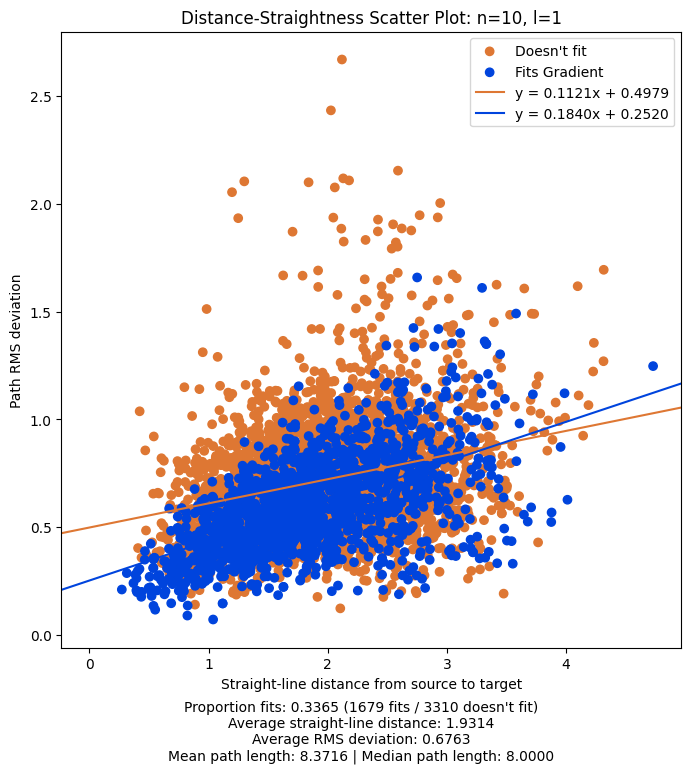

In [111]:
scatter_plot_results(msd_features, 'msd-results/results-n=10-d=10000-l=1', feature_distance_l1, 'n=10, l=1', 'n=10-l=1.png', False)

In [112]:
# scatter_plot_results(msd_features, 'msd-results/results-n=10-d=10000-l=2', feature_distance_l2, 'n=10, l=2', 'n=10-l=2.png', True)

Loading results...
Processing file #4750...
Calculating metrics...
Plotting...


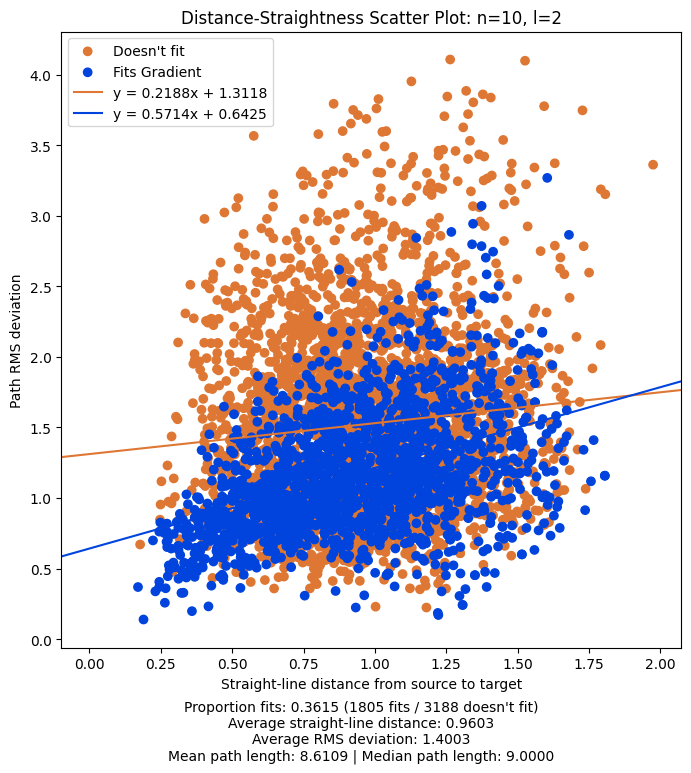

In [113]:
scatter_plot_results(msd_features, 'msd-results/results-n=10-d=10000-l=2', feature_distance_l2, 'n=10, l=2', 'n=10-l=2.png', False)

In [114]:
# scatter_plot_results(msd_features, 'msd-results/results-n=25-d=10000-l=1', feature_distance_l1, 'n=25, l=1', 'n=25-l=1.png', True)

Loading results...
Processing file #4750...
Calculating metrics...
Plotting...


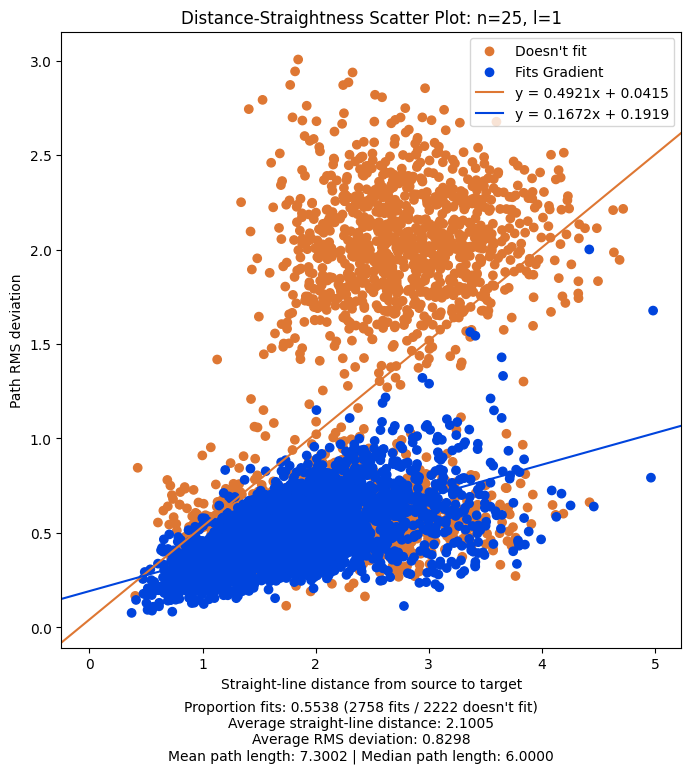

In [115]:
scatter_plot_results(msd_features, 'msd-results/results-n=25-d=10000-l=1', feature_distance_l1, 'n=25, l=1', 'n=25-l=1.png', False)

In [116]:
# scatter_plot_results(msd_features, 'msd-results/results-n=25-d=10000-l=2', feature_distance_l2, 'n=25, l=2', 'n=25-l=2.png', True)

Loading results...
Processing file #4750...
Calculating metrics...
Plotting...


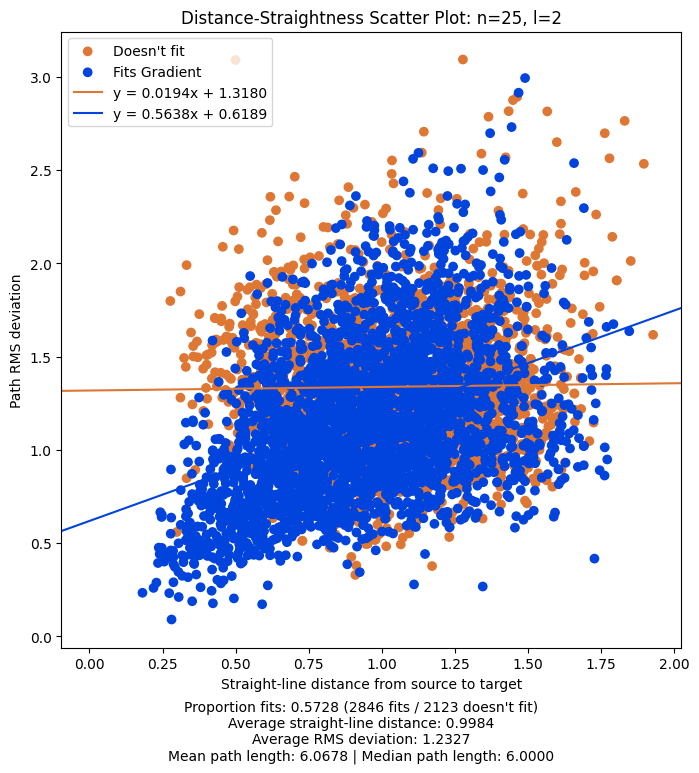

In [117]:
scatter_plot_results(msd_features, 'msd-results/results-n=25-d=10000-l=2', feature_distance_l2, 'n=25, l=2', 'n=25-l=2.png', False)

In [118]:
# scatter_plot_results(msd_features, 'msd-results/results-n=40-d=10000-l=1', feature_distance_l1, 'n=40, l=1', 'n=40-l=1.png', True)

Loading results...
Processing file #4750...
Calculating metrics...
Plotting...


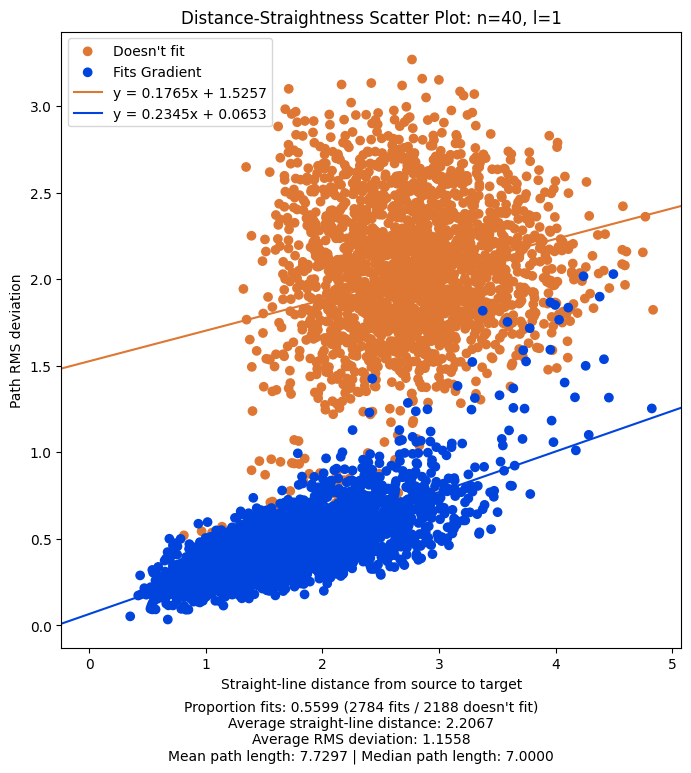

In [119]:
scatter_plot_results(msd_features, 'msd-results/results-n=40-d=10000-l=1', feature_distance_l1, 'n=40, l=1', 'n=40-l=1.png', False)

In [120]:
# scatter_plot_results(msd_features, 'msd-results/results-n=40-d=10000-l=2', feature_distance_l2, 'n=40, l=2', 'n=40-l=2.png', True)

Loading results...
Processing file #4750...
Calculating metrics...
Plotting...


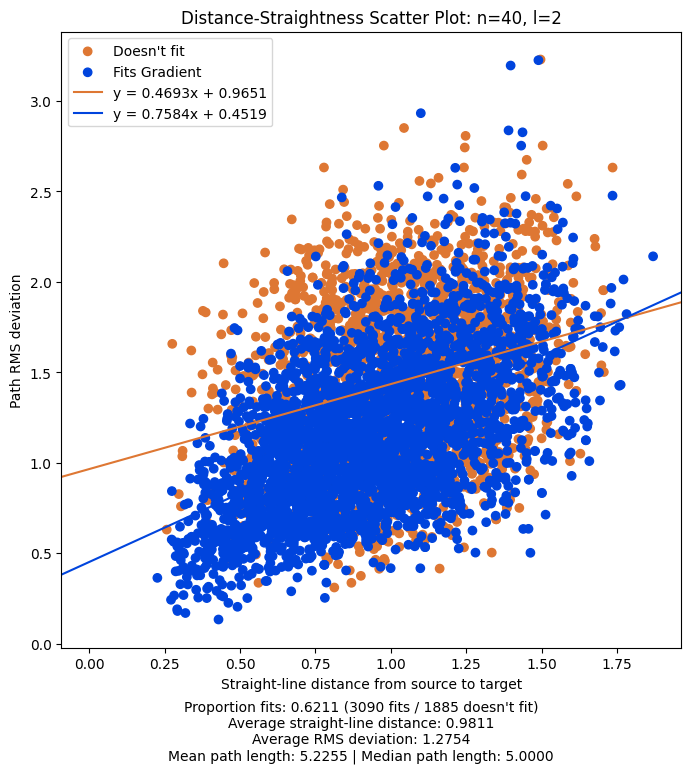

In [121]:
scatter_plot_results(msd_features, 'msd-results/results-n=40-d=10000-l=2', feature_distance_l2, 'n=40, l=2', 'n=40-l=2.png', False)

In [122]:
# scatter_plot_results(mfcc_features, 'msd-results/results-n=10-d=10000-l=1-f=mfcc', array_distance_l1, 'n=10, l=1', 'n=10-l=1-f=mfcc.png', True)

Loading results...
Processing file #4750...
Calculating metrics...
Plotting...


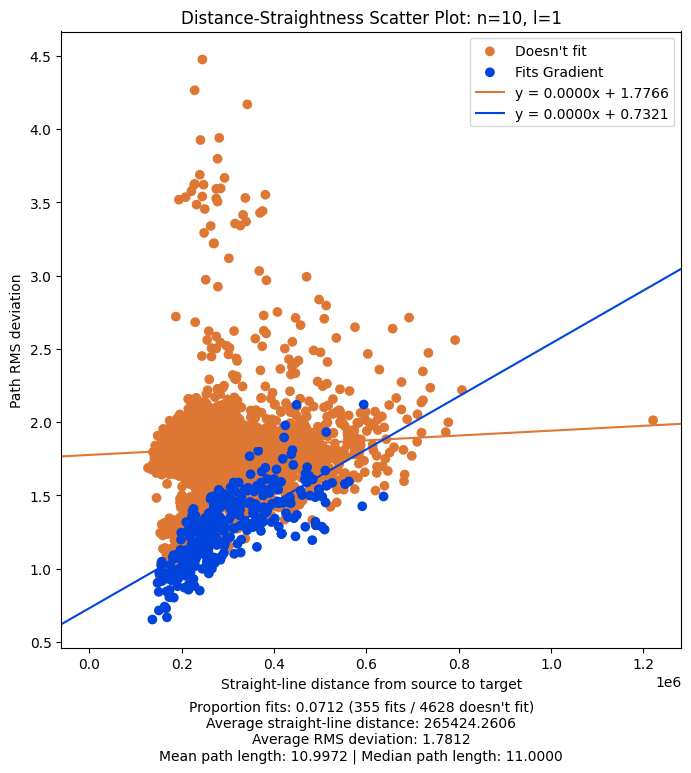

In [123]:
scatter_plot_results(mfcc_features, 'msd-results/results-n=10-d=10000-l=1-f=mfcc', array_distance_l1, 'n=10, l=1', 'n=10-l=1-f=mfcc.png', False)

In [124]:
# scatter_plot_results(mfcc_features, 'msd-results/results-n=25-d=10000-l=1-f=mfcc', array_distance_l1, 'n=25, l=1', 'n=25-l=1-f=mfcc.png', True)

Loading results...
Processing file #4750...
Calculating metrics...
Plotting...


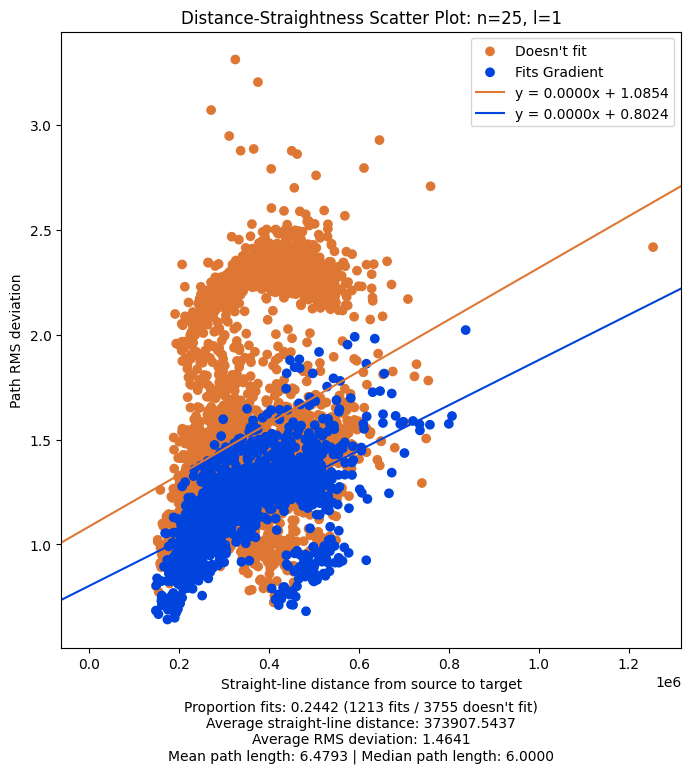

In [125]:
scatter_plot_results(mfcc_features, 'msd-results/results-n=25-d=10000-l=1-f=mfcc', array_distance_l1, 'n=25, l=1', 'n=25-l=1-f=mfcc.png', False)

In [126]:
# scatter_plot_results(mfcc_features, 'msd-results/results-n=40-d=10000-l=1-f=mfcc', array_distance_l1, 'n=40, l=1', 'n=40-l=1-f=mfcc.png', True)

Loading results...
Processing file #3000...
Calculating metrics...
Plotting...


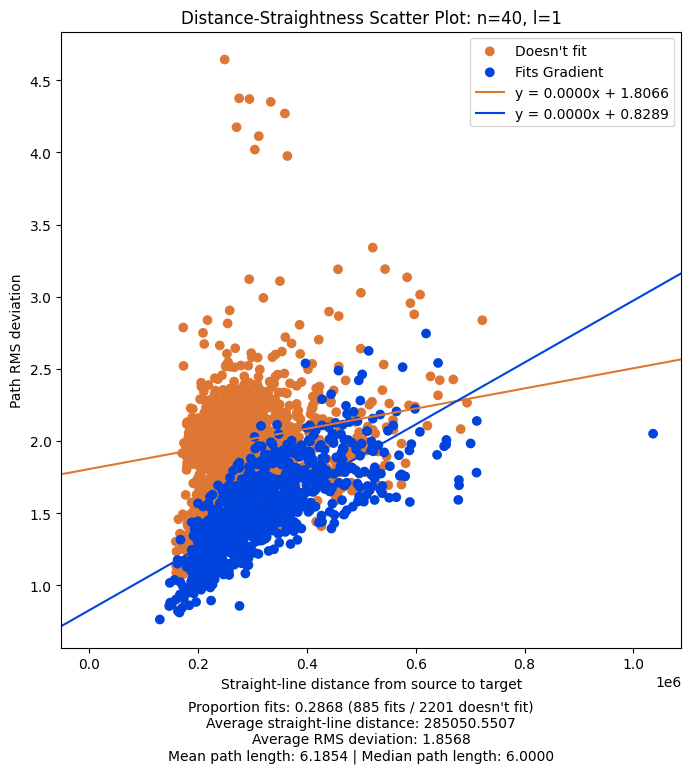

In [127]:
scatter_plot_results(mfcc_features, 'msd-results/results-n=40-d=10000-l=1-f=mfcc', array_distance_l1, 'n=40, l=1', 'n=40-l=1-f=mfcc.png', False)